# Основы работы с `PyTorch`


## Импорт

Как уже писали ранее, основные преимущества `PyTorch` заключаются в следующем.
* Использование приема автодифференцирования. Этот прием позволяет, не задумываясь о необходимости вычисления производных и их цепочек, проводить обучение нейронных сетей методом обратного распространения ошибки.
* Использование оптимизации вычислений под CPU и GPU.
* Встроенные реализации основных компонент архитектур глубоких нейронных сетей.

В этом ряду наиболее простым является возможность реализации линейного слоя и надстроек над ним. Попробуем реализовать такой слой в данном уроке.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print('version:',torch.version.__version__)

version: 2.2.1


In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [69]:
from torchinfo import summary

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Cuda is available:',torch.cuda.is_available())
    
    n_devices = torch.cuda.device_count()
    print('number of devices: %d'%(n_devices))
    
    for cnt_device in range(n_devices):
        print(torch.cuda.get_device_name(cnt_device))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


num_workers=os.cpu_count()
print ('available number of workers:',num_workers)
       
dtype = torch.float
torch.set_default_dtype(dtype) # float32
print('Current data type:',dtype)

Using device: cpu
available number of workers: 8
Current data type: torch.float32


In [6]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [7]:
seed = 42
torch.manual_seed(seed) #cpu
torch.cuda.manual_seed(seed) #gpu
np.random.seed(seed) #numpy
random.seed(seed) # random and transforms

torch.backends.cudnn.deterministic=True #cudnn
# torch.use_deterministic_algorithms(True)

In [8]:
def clean_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    to_remove = set()
    for k, v in globals().items():
        if isinstance(v, (torch.nn.Module)):
            to_remove.add(k)
    for k in to_remove:
        del globals()[k]
    gc.collect()

# Пример расчета задачи линейной регрессии

После того, как мы познакомились с некоторыми базовыми возможностями PyTorch попробуем записать линейную регрессию в рамках данного фреймворка.

Создадим набор данных для модели типа:

$y=w\cdotх+b + z$

где:
* Значение $w$ является наклоном.
* Значение $b$ — это смещение.
* $z$ - некоторый шум, неописываемый линейной моделью $\hat y=w\cdotх+b$

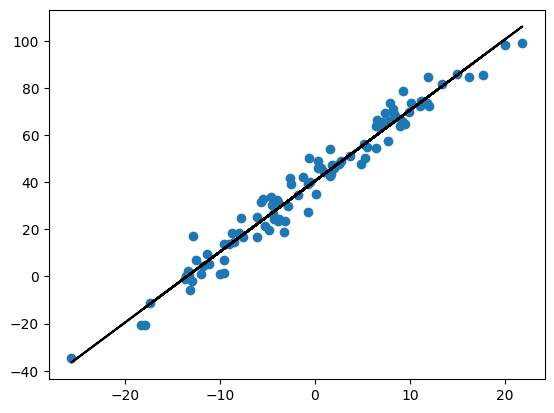

In [31]:
x = torch.randn(100, 1) * 10
y_clear = 3*x + 40.5
y = y_clear + 5 * torch.randn(100, 1)

plt.plot(x.cpu().numpy(),y.cpu().numpy(),'o')
plt.plot(x.cpu().numpy(),y_clear.cpu().numpy(),'-k')

Теперь попробуем применить линейнную регрессию для нашей модели. 

In [32]:
def model(x,w,b):
    return x * w + b

Проинициализируем параметры модели некоторыми случайными переменными

In [33]:
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

Зададим функцию потерь

$ MSE = \sum (y-x)^2 / N$

In [34]:
def mse(predicts, targets):
    diff = predicts - targets
    return torch.sum(torch.square(diff)) / diff.numel()

Посмотрим на начальные значения предсказаний и сравним их с ожидаемыми значениями путем подчета функции потерь (MSE)

In [35]:
predicts = model(x,w,b)
# print(predicts)

loss = mse(predicts, y)
print('loss = ',loss.data.cpu().numpy())

loss =  3271.7898


Пока значение функции потерь большое, модель будет давать большую ошибку предсказания.

Для снижения функции потерь будем использовать метод градиентного спуска.

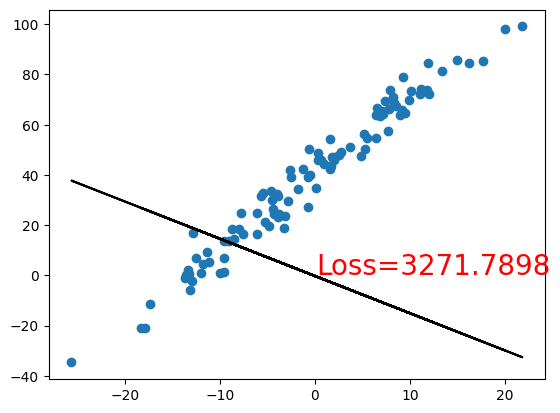

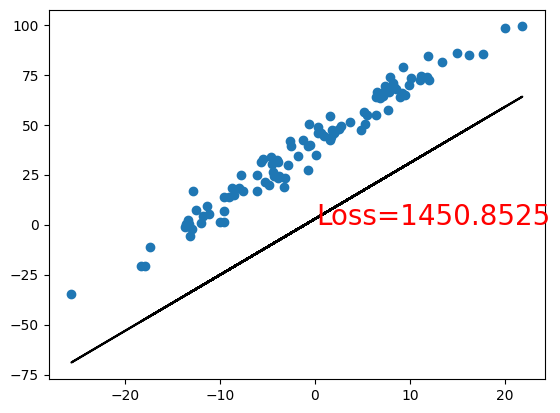

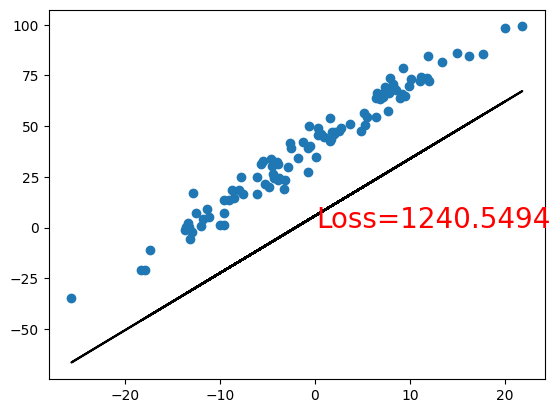

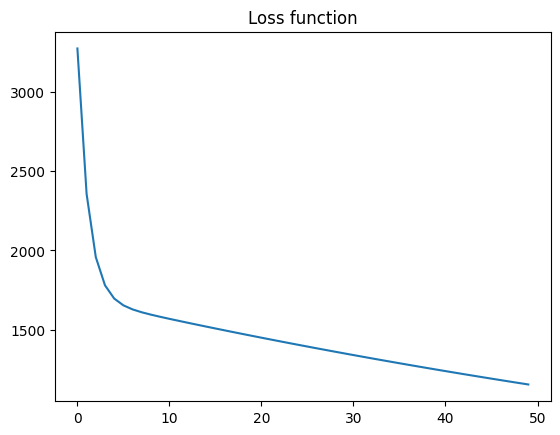

In [36]:
epochs = 50
LR = 0.002 

trainig = np.zeros(epochs)
for i in range(epochs):

    # FORWARD 
    predicts = model(x,w,b) # DAG
    loss = mse(predicts, y) # DAG
    
    trainig[i] = loss.data.cpu().numpy()

    #BACKWARD
    loss.backward() # DAG
    with torch.no_grad():
        # OPTIMIZER STEP
        w -= w.grad * LR
        b -= b.grad * LR
        
    # with torch.no_grad():   
        # OPTIMIZER ZERO_GRAD
        w.grad.zero_()
        b.grad.zero_()

    if(i%20 == 0):
        plt.plot(x.data.cpu().numpy(),y.data.cpu().numpy(),'o')
        plt.plot(x.data.cpu().numpy(),predicts.data.cpu().numpy(),'-k')
        plt.text(0.1, 0.1, 'Loss=%.4f' %(trainig[i]), fontdict={'size': 20, 'color': 'red'})
        plt.show()
        
plt.plot(trainig,)
plt.title('Loss function')
plt.show()

посмотрим на найденные значения наклона и смещения

In [37]:
print(w)
print(b)

tensor([2.8221], requires_grad=True)
tensor([7.1573], requires_grad=True)


## Задание

__1.__ Попробуйте перейти от задачи линйной регрессии к задаче полиномиальной регрессии.

__2.__ Часто задача регрессии решается с использованием регуляризации. Например, популярным является прием регуляризации Тихонова ($L_2$), или `LASSO` ($L_1$) регугляризация, а также их комибинации (эластичная регуляризация). При этом функция потерь должна быть дополнена в следующем виде:
    
```python
        loss = criterion(y_pred, y)
    
        l1_regularization = 0
        l2_regularization = 0
        
        for p in model.parameters():
            l1_regularization += torch.abs(p).sum()
            l2_regularization += torch.pow(p,2).sum()     

        loss += lambda_l1*l1_regularization + lambda_l2*l2_regularization
```
    
где `lambda_l1` и `lambda_l2` - это гиперпараметры регуляризации. Также норма может быть рассчитана ```torch.norm(model.weight, p=1) ```.
<!-- Также в процесс обучения может быть интегрирована, например, возможность ранней остановки по заданным условиям. Таким условиями могут быть отсутствие изменений или рост значения потерь для валидационного набора данных.

Также отметим, что функция `SGD` позволяет реализовать метод Нестеров, при выставлении `nesterov=True`, в параметрах инициализации. -->
__Предлагается__ реализовать регрессию с регуляризацией. 

# Модель в `PyTorch`

Попробуем реализовать регрессию в более популярном и принятом в `PyTorch` виде.

Для построения линейной регрессии используем класс `nn.Linear` — фактически данный класс реализует выражение `y=Wx+b`.


In [38]:
from torch import nn

In [40]:
model = nn.Linear(in_features=1, out_features=1)

Если работа в `PyTorch` производится с использованием `GPU`, то модель необходимо отправить на устройство. Для этого вы воспользуемся методом `to()` c указанием устройства.

Отметим также, что в случае, если обучение производится с использованием нескольких `GPU`, то модель рекомендуется загрузить с использованием контейнера `nn.DataParallel`. Например так:
```model = nn.DataParallel(model, device_ids=devices).to(devices[0])```. Подробней про параллелизм данных в `PyTorch` можно прочитать, например, [тут](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html).

In [41]:
model = model.to(device)

__Отметим!__

Основной способ, предлагаемый в `PyTorch` для создания моделей, — это их наследование от базового класса `torch.nn.Module`. Однако, для упрощения, в некоторых случаях можно использовать контейнер `torch.nn.Sequential()` — конструкция которого знакома многим по опыту работы с `tf.keras`. 

В созданном классе переопределим функцию инициализации — конструктор класса `__init__` и функцию, реализующую прямое распространение ошибки `forward`. 

В случае с `nn.Model` регрессия могла бы быть записана следующим образом.
```python
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x):
        return self.l1(x)
```
При этом инициализация модели могла бы быть записана следующим образом.
```python
model =  LinearRegression()   
```

Также заметим, что линейный слой мог бы быть вызванным из `PyTorch` в процедурном стиле с указанием весовых параметров как:
```python
    x = F.linear(x, weight=w.view(1,-1), bias=b)
```

>Важно отметить что в последних версиях `PyTorch` помимо слоя `nn.Linear` появился слой [`nn.LazyLinear`](https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html). Отличием этой реализации является отсутствие необходимости указания числа входных параметров. Это число будет определено при первом вызове модели. С использованием слоя `nn.LazyLinear` модель бы выглядела как:
```python
   model = nn.Sequential(nn.LazyLinear(out_features=1)) 
```

>В настоящее время в общем случае рекомендуется использовать контейнер типа `nn.Sequential` для простых последовательностей. В том числе, часто результат `nn.Sequential` является частью более сложной модели, описанной в `nn.Model`.

Посмотрим на набор параметров созданной модели, по этим параметрам будет вычисляться градиент. Сейчас параметры проинициализированы некоторыми случайными значениями.

In [42]:
w,b = model.parameters()
print(w,b)

Parameter containing:
tensor([[0.5738]], requires_grad=True) Parameter containing:
tensor([-0.9941], requires_grad=True)


Теперь выберем стандартную функцию потерь и оптимизатор (метод градиентного спуска). 

Отметим, что при использовании `GPU` функция потерь также должна быть загружена на вычислительное устройство — это тоже часть вычислительного графа.

In [43]:
LR = 0.005
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = criterion.to(device)


Проведем обучение сети. В данном случае нам не понадобится вручную обновлять значения весов и делать некоторые другие операции из проведенных выше. Все эти операции за нас сделает экземпляр класса `optimizer`.

Epoch:  1  Loss:  260.988037109375
Epoch:  21  Loss:  183.95248413085938
Epoch:  41  Loss:  132.36485290527344
Epoch:  61  Loss:  97.81866455078125
Epoch:  81  Loss:  74.68466186523438
Epoch:  101  Loss:  59.19271469116211
Epoch:  121  Loss:  48.81844711303711
Epoch:  141  Loss:  41.871219635009766
Epoch:  161  Loss:  37.218875885009766
Epoch:  181  Loss:  34.103389739990234
Epoch:  201  Loss:  32.01708984375
Epoch:  221  Loss:  30.620006561279297
Epoch:  241  Loss:  29.684389114379883
Epoch:  261  Loss:  29.057863235473633
Epoch:  281  Loss:  28.638317108154297


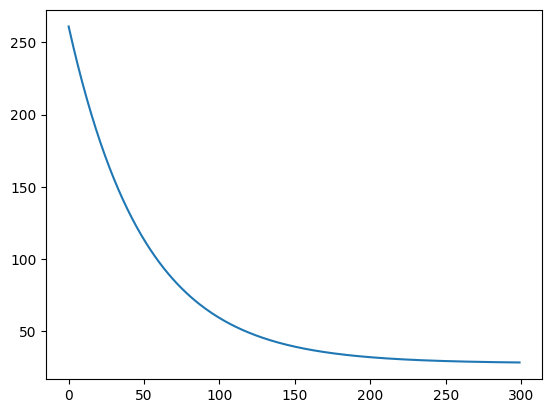

In [46]:
epochs = 300
losses = np.zeros(epochs)

for i in range(epochs):
    predict = model.forward(x)
    
    loss = criterion(predict, y)

    losses[i] = loss.data.cpu().numpy()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if(i//20 == i/20):
        print("Epoch: ", i+1, " Loss: ", loss.item())

plt.plot(losses)

Посмотрим на то, какие теперь получились значения наших параметров.

In [47]:
[w, b] = model.parameters()
print(w,b)


Parameter containing:
tensor([[3.0004]], requires_grad=True) Parameter containing:
tensor([39.9037], requires_grad=True)


Визуализируем результат предсказания.

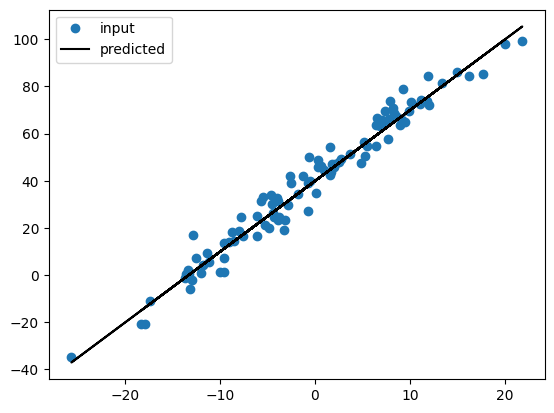

In [48]:
predict = model.forward(x)
plt.plot(x.data.cpu().numpy(),
         y.data.cpu().numpy(),'o', 
         label='input')
plt.plot(x.data.cpu().numpy(),
         predict.data.cpu().numpy(),'-k', 
         label='predicted')
plt.legend()
plt.show()

Теперь попробуем сохранить модель.

In [50]:
torch.save(model.state_dict(), 'test_module.pt')

Удалим модель.

In [51]:
del(model)

Теперь заново загруим модель, но назовем ее ```new_model```.

In [53]:
new_state_dict = torch.load('test_module.pt')
new_model = nn.Linear(in_features=1, out_features=1)
new_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [57]:
torch.save(new_model, 'test.pt')
model = torch.load('test.pt')




In [61]:
dict2save = {'model':model, 'opt':optimizer, 'hyp':{'LR':LR}}
torch.save(dict2save, 'test_dict.pt')
new_dict = torch.load('test_dict.pt')
model = new_dict['model']
new_dict['hyp']['LR']

0.005

*Отметим*, что для модели в классовом стиле тут не пришлось бы переписывать модель, а необходимо бы было лишь создать новый экземпляр класса,
```python
new_model = LinearRegression()
```

проверим, что новая модель соответствует обученной прежде

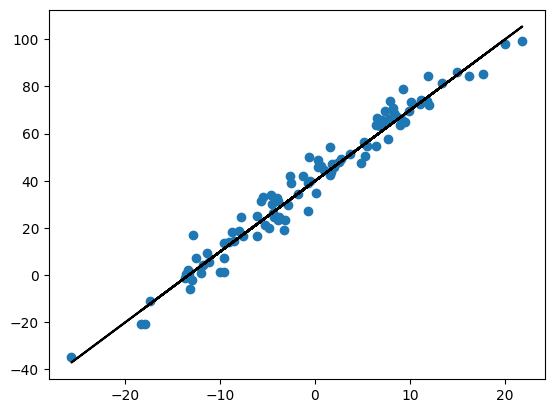

In [63]:
predict = model.forward(x)
plt.plot(x.data.cpu().numpy(),
         y.data.cpu().numpy(),'o')
plt.plot(x.data.cpu().numpy(),
         predict.data.cpu().numpy(),'-k')

Отметим также возможность задания функции `backward` [самостоятельно](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-defining-new-autograd-functions)

Для закрепления результата давайте посмотрим на реализацию многоклассовой (softmax) регрессии в `PyTorch`.

Создадим набор данных из трех классов.


In [64]:
from sklearn import datasets
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
import numpy as np

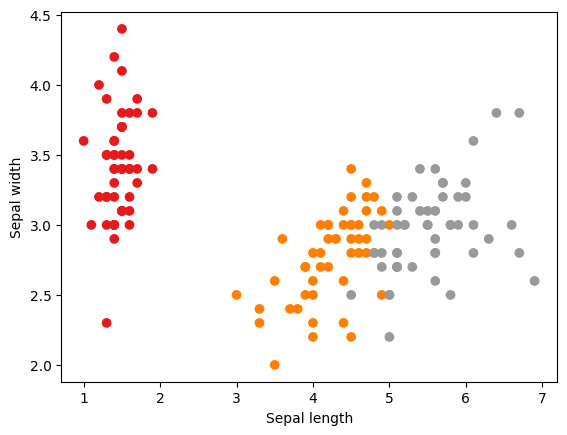

(150, 2)
(150,)
torch.Size([105, 2]) torch.Size([45, 2]) torch.Size([105, 1]) torch.Size([45, 1])


In [67]:
iris = datasets.load_iris()

x = iris.data[:,[2,1] ]
y = (iris.target) 

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

# standardize
x[:,0] = (x[:,0] - x[:,0].mean()) / x[:,0].std()
x[:,1] = (x[:,1] - x[:,1].mean()) / x[:,1].std()

print(x.shape)
print(y.shape)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_train = torch.from_numpy(x_train.astype(np.float32))
x_test  = torch.from_numpy(x_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_test  = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Запишем модель регрессии в стиле `nn.Sequential`

In [73]:
model = nn.Sequential(nn.Linear(in_features=x_train.shape[1], out_features=3),
                      nn.LogSoftmax(dim=1))

summary(model,input_size = x.shape[:])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [150, 3]                  --
├─Linear: 1-1                            [150, 3]                  9
├─LogSoftmax: 1-2                        [150, 3]                  --
Total params: 9
Trainable params: 9
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

<blockquote>
<em>Модель в  стиле класса имела бы следующий вид.</em>

  ```python
  class SoftmaxRegression(nn.Module):    
      
      def __init__(self, 
                  in_features = 2, 
                  n_classes   = 3):
          
          super().__init__()
          
          self.l1 = nn.Linear(in_features=in_features, out_features=n_classes)
          
      def forward(self, x):
          return torch.nn.functional.log_softmax(self.l1(x), dim=1)
  ```
<blockquote>
  а инициализация модели могла бы быть записана как
  
  ```python
  model = SoftmaxRegression(x_train.shape[1],3)
  summary(model,input_size = x.shape[1:])
  ```

  *Ометим*, что в будущих практиках мы перейдем к стилю классов,  так как тот является более гибким и более распростронен для `PyTorch`.

Теперь перейдем к обучению модели.

В качестве функции потерь выберем `nn.NLLLoss()` (`negative log likelihood loss`) — по сути, кросс-энтропию. Эта функция потерь ждет на входе т. н. логит (`logit` — `log probabilities`). Поэтому тут используется функция активации `log_softmax` вместо `softmax`. 

Отметим, что данный тип функции потерь относится к *sparse categorical cross entropy*, то есть не требует *one hot* кодирования. 

Важно отметить, что самая распространенная ошибка новичков — несоответствие между функцией потерь и выходной функцией активации. Например, в `PyTorch` есть функция потерь `nn.CrossEntropyLoss`. Эта функция потерь в `PyTorch` выполняет две операции: `nn.LogSoftmax` и `nn.NLLLoss`. Следовательно, входом для этого модуля потерь должен быть выход последнего линейного слоя. Не применяйте `softmax` перед функцией `nn.CrossEntropyLoss`. В противном случае `PyTorch` применит `log-softmax` к выводам `softmax`, что значительно ухудшит производительность и доставит вам головную боль.

Также отметим, что указанный функционал можно использовать в функциональном стиле:
* `nn.CrossEntropyLoss` $\to$ `torch.nn.functional.cross_entropy`
* `nn.NLLLoss` $\to$ `torch.nn.functional.nll_loss`
* `nn.LogSoftmax` $\to$ `torch.log_softmax`

В качестве оптимизатора зададим `torch.optim.SGD`.

In [74]:
LR = 0.4

criterion = nn.NLLLoss()#nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

Epoch:  1  Loss:  1.6577633619308472
Epoch:  201  Loss:  0.21261416375637054
Epoch:  401  Loss:  0.16245238482952118
Epoch:  601  Loss:  0.14042186737060547
Epoch:  801  Loss:  0.12801334261894226


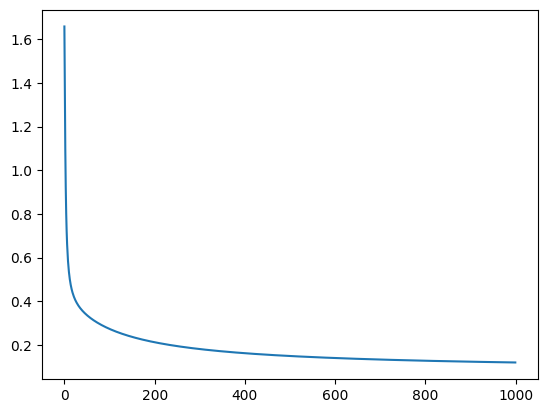

In [75]:
epochs = 1000
losses = np.zeros(epochs)

for i in range(epochs):

    predict = model.forward(x_train.to(device))

    loss = criterion(predict, torch.squeeze(y_train).type(torch.LongTensor).to(device))

    losses[i] = loss.data.cpu().numpy()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if(i//(epochs//5) == i/(epochs//5)):
        print("Epoch: ", i+1, " Loss: ", loss.item())

plt.plot(losses)

В результате функция предсказания выдает 3 класса в виде массива. 

Мы можем построить данные классы отдельно для того, чтобы посмотреть на ошибки.

torch.Size([150, 3])


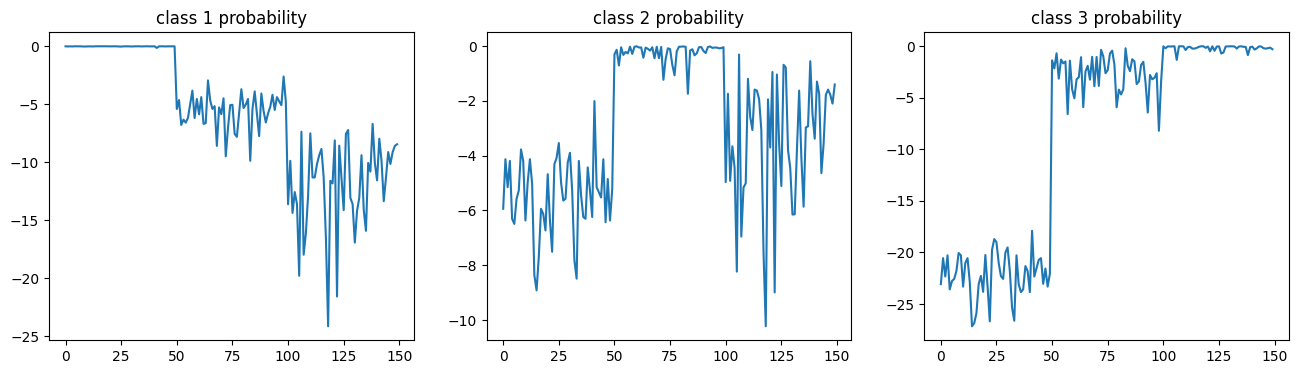

In [77]:
predict = model.forward(torch.from_numpy(x).type(torch.float).to(device))
print(predict.shape)
Z = predict.detach().cpu().numpy()
plt.figure(figsize = (16,4))
plt.subplot(1,3,1);plt.plot(Z[:,0]);plt.title('class 1 probability')
plt.subplot(1,3,2);plt.plot(Z[:,1]);plt.title('class 2 probability')
plt.subplot(1,3,3);plt.plot(Z[:,2]);plt.title('class 3 probability')
plt.show()

Также полезным будет визуализация нашего классификатора

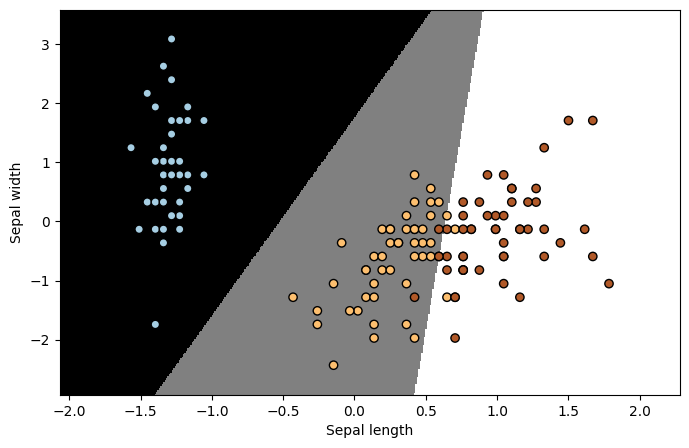

In [78]:
import matplotlib.pyplot as plt


x1_min, x1_max = x[:, 0].min() - .5, x[:, 0].max() + .5
x2_min, x2_max = x[:, 1].min() - .5, x[:, 1].max() + .5
h = .01
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
 
    
    
predict = model.forward(torch.from_numpy(np.c_[xx1.ravel(), xx2.ravel()]).type(torch.float).to(device))
Z = predict.detach().cpu().numpy().argmax(axis=1).reshape(xx1.shape)

plt.figure(figsize=(8, 5))

plt.pcolormesh(xx1, xx2, Z,shading='auto', cmap=plt.cm.gray)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())


plt.show()

Посмотрим на то, чем отличается предсказанный класс и вероятность его предсказания. 

In [79]:
idxs = np.random.randint(0,len(x),5)
x_t = torch.from_numpy(x[idxs]).type(torch.float).to(device)
y_t = torch.from_numpy(y[idxs]).type(torch.long).to(device)
x_t.shape, y_t.shape

(torch.Size([5, 2]), torch.Size([5]))

In [80]:
def x_to_probs(model, x):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model(x)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    probs = [torch.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    return preds, probs

In [81]:
preds, probs = x_to_probs(model, x_t)

import pandas as pd
pd.DataFrame({'class':y_t.numpy(),'predict':preds, 'probablity score':probs})


,class,predict,probablity score
0,2,2,0.992698
1,1,1,0.966057
2,0,0,0.999766
3,2,1,0.732330
4,1,1,0.967316


## Задания.

__1.__ Перепишите модель логистической регрессии  с использованием шаблона `Sequential`. 

<details>
<summary>Click here for hint</summary>
```python

       model = nn.Sequential(
        nn.Linear(in_features=x_train.shape[1], out_features=1), 
        )      
```
    



__2.__ Перепишите модель линейного слоя используя явно заданные параметры (весовые коэффициенты и смещения).

<details>
    
```python
    class Linear(nn.Module):
        def __init__(self, dim_in, dim_out):
            super().__init__()
            self.weights = nn.Parameter(torch.rand((dim_in, dim_out)))
            self.bias = nn.Parameter(torch.rand(dim_out))

        def forward(self, X):

            return X@self.weights + self.bias
```

__3.__ Перепешите модель `softmax regression` с использованием `nn.CrossEntropyLoss` и  `nn.LazyLinear`
